In [1]:
1+1

2

In [2]:
from pathlib import Path
import os
import time
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

from data_loader import *
from model import *
from test import *


# pre-process
def pre_proc(tau, block):
    '''log(tau), 95%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 95)
    bln = np.ones(len(tau), 'bool')#tau_sum <= limit
    tau = np.log(tau)
    return (tau[bln],  block[bln])

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.exp(-np.exp(tau))
    return tau

def load_FGPA(FGPA, train_ousize, DM_param):
    nx, ny, nz = (DM_param.pix / train_ousize).astype('int')
    FGPA = FGPA.reshape(nx, train_ousize[0], ny, train_ousize[1], DM_param.pix)\
        .transpose(0, 2, 1, 3, 4).reshape(-1, train_ousize[0], train_ousize[1], DM_param.pix)

    x = (np.arange(nx)*(train_ousize[0]) + (train_ousize[0]-1)/2)
    y = (np.arange(ny)*(train_ousize[1]) + (train_ousize[1]-1)/2)
    z = (np.arange(nz)*(train_ousize[2]) + (train_ousize[2]-1)/2)
    
    cx = x.repeat(ny*nz).reshape(nx,ny,nz).transpose(0,1,2).flatten()
    cy = y.repeat(nz*nx).reshape(ny,nz,nx).transpose(2,0,1).flatten()
    cz = z.repeat(nx*ny).reshape(nz,nx,ny).transpose(1,2,0).flatten()
    block = np.array([cx, cy, cz]).T.reshape(-1, nz, 3)

    return FGPA




# Path and data file name
folder  = Path.cwd().parent / 'Illustris1'
DM_name = ['deltaDM_Illustris1_L75_N600_v2.fits', 
            'vx_DM_Illustris1_L75_N600.fits',
            'vy_DM_Illustris1_L75_N600.fits',
            'vz_DM_Illustris1_L75_N600.fits']
ske_name = 'spectra_Illustris1_N600_xaxis.npy'
FGPA_name = 'tau_normed_FGPA_smooth250kpc_therbr_RSD_Illustris-1_snap68_L75_N600_cic_xaxis.fits'



# hyper parameters
train_insize = np.array([11, 11, 141]) # x, y, z respctively
train_ousize = np.array([1, 1, 75]) # x, y, z respctively
test_batch = 50

In [3]:
localtime_n = ['2020-12-24 23:42:28']
localtime_i = localtime_n[0]
localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')


# device used to train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(device=device.index))


# load dark matter data
print('Loading dark matter...')
DM_general = load_DM(folder, DM_name)
DM_general = DM_general.transpose(0,3,2,1)
DM_general = DM_general[[0,3,2,1]]
# basic paramters
DM_param.pix  = len(DM_general[0])
DM_param.len  = 75 # in Mpc/h
DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
# test
if DM_general.shape[1]<train_insize.min():
    raise ValueError('DarkMatter cube size',
        DM_general.shape, 'is too small for train size', train_insize, '.')
DM_general = torch.tensor(DM_general).float()


# load skewers
print('Loading skewers...')
ske, block = load_skewers(folder, ske_name, train_ousize, DM_param)
#ske_FGPA, block = load_skewers(folder, FGPA_name, train_ousize, DM_param)
skeFGPA_file = fits.open(folder/FGPA_name)
ske_FGPA = skeFGPA_file[0].data
skeFGPA_file.close()
ske_FGPA = ske_FGPA.transpose(2,1,0)
ske_FGPA = load_FGPA(ske_FGPA, train_ousize, DM_param)
# basic parameters
ske_len = int(ske.shape[-1])


# divide the sample to training, validation set, and test set.
print('Setting test set...')
'''
with open("id_seperate/id_seperate_%s.txt"\
          %time.strftime("%Y-%m-%d_%H:%M:%S", localtime), "r") as f:
    aa = f.readlines()
    id_seperate = np.array(list(aa[0][::3])).astype('int')
    del aa
f.close()
'''
id_seperate = (np.concatenate((np.ones(36000), np.zeros(360000-36000)))*3).astype(int)
np.random.shuffle(id_seperate)

test_ske, test_block = load_test(ske, block, id_seperate,
                                 train_ousize, test_batch, pre_proc)
test_FGPA, test_block = load_test(ske_FGPA, block, id_seperate,
                                 train_ousize, test_batch, pre_proc)
del id_seperate

Using device: Quadro P6000
Loading dark matter...
Loading skewers...
Setting test set...


In [4]:
from scipy import optimize
def norm_specs(skewers,redshift):
    tauevo = 0.001845*(1+redshift)**3.924 #optical depth corresponding to the mean-flux of Faucher-Giguere et al. 2008 
    fobs = np.exp(-tauevo)
    def fun(a): return np.mean(np.exp(-a*skewers)-fobs)
    a = optimize.newton(fun, 1)    
    return a
rs = 2.0020281392528516 #redshift of the snapshot


# load model
print('Loading model...')
model = get_residual_network().float().to(device)
model.load_state_dict(torch.load('params/params_%s.pkl'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
'''
model.load_state_dict(torch.load('params/HyPhy_%s'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
'''


# loss
criterion = nn.L1Loss()


# record starr time
start_time = time.time()


# start test
print('Begin testing...')
test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                        test_batch, train_insize, model, criterion, device, start_time)

print("Test Summary: ")
print("\tTest loss: {}".format(test_losses))

# restore test skewers
print('Restoring test skewers...')
nz = (ske_len/train_ousize[2]).astype('int')
test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
test_ske = test_ske.numpy().reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
test_FGPA = test_FGPA.numpy().reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)

Loading model...
Begin testing...
Step [ 100/5760] Loss: 0.4405, Time: 16.9756
Step [ 200/5760] Loss: 0.4216, Time: 33.1405
Step [ 300/5760] Loss: 0.3691, Time: 47.7942
Step [ 400/5760] Loss: 0.9351, Time: 62.6302
Step [ 500/5760] Loss: 0.4005, Time: 76.9521
Step [ 600/5760] Loss: 1.4053, Time: 91.6582
Step [ 700/5760] Loss: 0.4477, Time: 106.3953
Step [ 800/5760] Loss: 0.3749, Time: 120.8632
Step [ 900/5760] Loss: 0.6072, Time: 134.9492
Step [1000/5760] Loss: 0.3537, Time: 149.4329
Step [1100/5760] Loss: 0.4321, Time: 164.1595
Step [1200/5760] Loss: 0.3613, Time: 178.5278
Step [1300/5760] Loss: 0.8338, Time: 193.2115
Step [1400/5760] Loss: 0.4764, Time: 207.5734
Step [1500/5760] Loss: 0.5022, Time: 221.9740
Step [1600/5760] Loss: 0.3644, Time: 236.6330
Step [1700/5760] Loss: 0.4159, Time: 251.4677
Step [1800/5760] Loss: 0.8513, Time: 266.1126
Step [1900/5760] Loss: 0.3667, Time: 280.5596
Step [2000/5760] Loss: 0.6509, Time: 296.2741
Step [2100/5760] Loss: 0.5091, Time: 311.0848
Step [

In [7]:
# this parameter deviates the PDF of ML F and hydro
# why so large difference? maybe train on normalized skewers
normalization_outp, normalization_test

(0.5182287315064024, 0.3818322237583127)

Loading model...
Begin testing...
Step [ 100/5760] Loss: 0.7536, Time: 16.9398
Step [ 200/5760] Loss: 0.4416, Time: 32.8803
Step [ 300/5760] Loss: 0.5728, Time: 48.2453
Step [ 400/5760] Loss: 0.8474, Time: 62.0694
Step [ 500/5760] Loss: 0.4343, Time: 76.5206
Step [ 600/5760] Loss: 0.5537, Time: 90.5750
Step [ 700/5760] Loss: 0.4771, Time: 104.7813
Step [ 800/5760] Loss: 0.4207, Time: 119.1956
Step [ 900/5760] Loss: 0.6647, Time: 133.1126
Step [1000/5760] Loss: 0.4460, Time: 147.5072
Step [1100/5760] Loss: 0.5392, Time: 161.7675
Step [1200/5760] Loss: 0.3938, Time: 175.8905
Step [1300/5760] Loss: 0.3910, Time: 190.0988
Step [1400/5760] Loss: 0.4334, Time: 204.3712
Step [1500/5760] Loss: 0.3813, Time: 218.7788
Step [1600/5760] Loss: 0.3944, Time: 232.7002
Step [1700/5760] Loss: 0.6187, Time: 247.0994
Step [1800/5760] Loss: 0.3530, Time: 261.7626
Step [1900/5760] Loss: 0.6398, Time: 275.7549
Step [2000/5760] Loss: 0.4342, Time: 290.0646
Step [2100/5760] Loss: 0.8205, Time: 304.4180
Step [

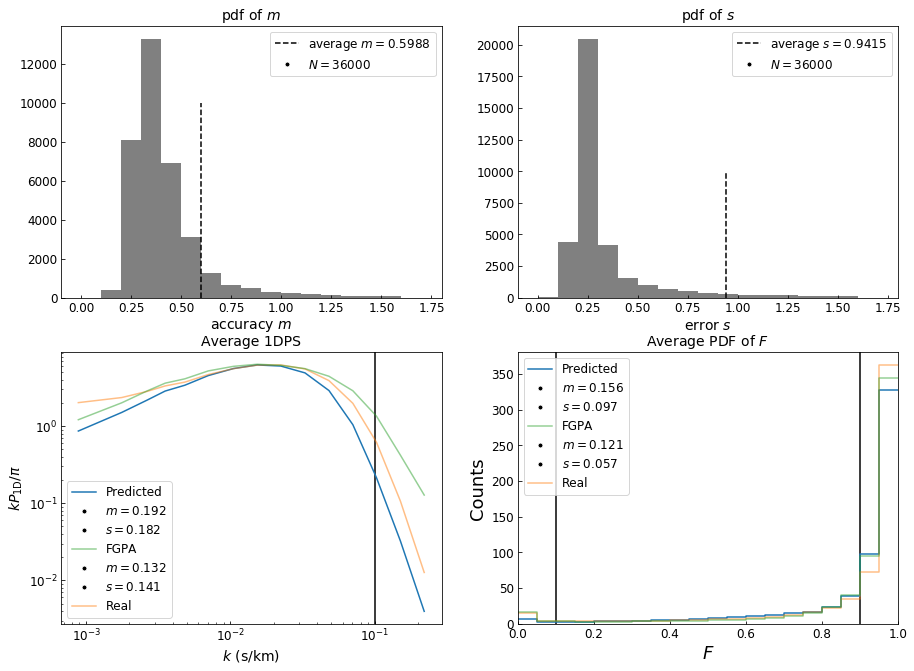

In [4]:
from scipy import optimize
def norm_specs(skewers,redshift):
    tauevo = 0.001845*(1+redshift)**3.924 #optical depth corresponding to the mean-flux of Faucher-Giguere et al. 2008 
    fobs = np.exp(-tauevo)
    def fun(a): return np.mean(np.exp(-a*skewers)-fobs)
    a = optimize.newton(fun, 1)    
    return a
rs = 2.0020281392528516 #redshift of the snapshot


# load model
print('Loading model...')
model = get_residual_network().float().to(device)
model.load_state_dict(torch.load('params/params_%s.pkl'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
'''
model.load_state_dict(torch.load('params/HyPhy_%s'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
'''


# loss
criterion = nn.L1Loss()


# record starr time
start_time = time.time()


# start test
print('Begin testing...')
test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                        test_batch, train_insize, model, criterion, device, start_time)

print("Test Summary: ")
print("\tTest loss: {}".format(test_losses))

# restore test skewers
print('Restoring test skewers...')
nz = (ske_len/train_ousize[2]).astype('int')
test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
test_ske = test_ske.numpy().reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
test_FGPA = test_FGPA.numpy().reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
tau = np.exp(test_outp)
normalization = norm_specs(tau,rs) #determine the normalization constant on the whole tau box
tau_normed = normalization*tau #normalized optical depth
test_outp = np.exp(-normalization*tau) #normalized flux

tau = np.exp(test_ske)
normalization = norm_specs(tau,rs) #determine the normalization constant on the whole tau box
tau_normed = normalization*tau #normalized optical depth
test_ske = np.exp(-normalization*tau) #normalized flux

tau = np.exp(test_FGPA)
normalization = norm_specs(tau,rs) #determine the normalization constant on the whole tau box
tau_normed = normalization*tau #normalized optical depth
test_FGPA = np.exp(-normalization*tau) #normalized flux
'''
test_outp = toF_proc(test_outp)
test_ske  = toF_proc(test_ske)
test_FGPA = toF_proc(test_FGPA)
'''
test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
del test_coord, xcoor, ycoor, mesh


print('Plotting example skewers...')
# generate comparison images
folder_outp = Path.cwd()/'test_figs'/('%s_x'\
        %time.strftime("%Y-%m-%d_%H:%M:%S_FGPA", localtime))
if not os.path.exists(folder_outp):
    os.makedirs(folder_outp)


from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
z = 2.0
h= 0.704
cosmo = FlatLambdaCDM(H0=100.0*h, Om0=0.2726, Ob0=0.0456)
Hz = cosmo.H(z)
a = 1.0 / (1.0 + z)
v_end  = (a * Hz * 75/h*u.Mpc).to(u.km / u.s).value
F_mean = np.array([test_ske.mean(), test_outp.mean(), test_FGPA.mean()])
print(F_mean)

nrange = min(len(test_ske), 50)
test_sp = np.arange(len(test_ske))
np.random.seed(99)
np.random.shuffle(test_sp)
test_sp1 = test_sp[:int(nrange)].astype('int')
test_sp2 = test_sp[int(nrange):].astype('int')

bins = int(15)
accuracy = AverageMeter()
rela_err = AverageMeter()
accu_arr = np.zeros(len(test_ske))
erro_arr = np.zeros(len(test_ske))
oneDPS   = np.zeros(shape=(4, len(test_ske), bins))


# loop
for i, ii in enumerate(test_sp1):
    print('Plotting {:{}d}/{}, y{:03d}z{:03d}.png...'\
            .format((i+1), int(np.log10(nrange)+1), nrange,
                    test_block[ii,0], test_block[ii,1]))

    test_block_i = test_block[ii]
    test_outp_i = test_outp[ii]
    test_ske_i = test_ske[ii]
    test_FGPA_i = test_FGPA[ii]
    test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

    stat_i = test_plot(test_block_i, test_outp_i, test_ske_i, test_FGPA_i,
                      test_DM_i, F_mean, v_end, folder_outp, bins)
    accuracy_i, rela_err_i = stat_i[[4,5]]
    accuracy.update(accuracy_i, 1)
    rela_err.update(rela_err_i, 1)
    accu_arr[ii] = accuracy_i
    erro_arr[ii] = rela_err_i
    oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2], stat_i[3]

print('Measuring accuracy of the left skewers...')
for i, ii in enumerate(test_sp2):

    test_block_i = test_block[ii]
    test_outp_i = test_outp[ii]
    test_ske_i = test_ske[ii]
    test_FGPA_i = test_FGPA[ii]
    test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

    stat_i = test_accuracy(test_block_i, test_outp_i, test_ske_i, test_FGPA_i,
                          F_mean, v_end, folder_outp, bins)
    accuracy_i, rela_err_i = stat_i[[4,5]]
    accuracy.update(accuracy_i, 1)
    rela_err.update(rela_err_i, 1)
    accu_arr[ii] = accuracy_i
    erro_arr[ii] = rela_err_i
    oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2], stat_i[3]


print('Plotting average 1DPS and PDF...')
#oneDPS_backup = oneDPS
oneDPS = oneDPS.mean(axis=1)
oneDPS = oneDPS[~np.isnan(oneDPS)].reshape(4,-1)
bln = oneDPS[0]<0.1
accuracy_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].mean()
rela_err_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].std()
accuracy_FGPA = np.abs((oneDPS[3]-oneDPS[2])/oneDPS[2])[bln].mean()
rela_err_FGPA = np.abs((oneDPS[3]-oneDPS[2])/oneDPS[2])[bln].std()

outp_hist, F_hist = np.histogram(test_outp, bins=np.arange(0,1.05,0.05))
test_hist, F_hist = np.histogram(test_ske,  bins=np.arange(0,1.05,0.05))
FGPA_hist, F_hist = np.histogram(test_FGPA, bins=np.arange(0,1.05,0.05))
outp_hist = np.append(outp_hist, outp_hist[-1]) / len(test_ske)
test_hist = np.append(test_hist, test_hist[-1]) / len(test_ske)
FGPA_hist = np.append(FGPA_hist, FGPA_hist[-1]) / len(test_ske)
bln = (F_hist>=0.1) & (F_hist<0.9)
accuracy_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].mean()
rela_err_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].std()
m_hist_FGPA = np.abs((FGPA_hist-test_hist)/test_hist)[bln].mean()
s_hist_FGPA = np.abs((FGPA_hist-test_hist)/test_hist)[bln].std()


fig, axes = plt.subplots(2,2,figsize=(15,11))

p0=axes[0,0].hist(accu_arr, color='grey', bins=np.arange(0, 1.7, 0.1))
axes[0,0].set_xlim(-0.1, 1.8)
axes[0,0].set_ylim(axes[0,0].get_ylim())
p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
axes[0,0].set_title('pdf of $m$', fontsize=14)
axes[0,0].tick_params(labelsize=12, direction='in')
customs = [p1, 
          Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='k', markersize=5)]
axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                        '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

axes[0,1].hist(erro_arr, color='grey', bins=np.arange(0, 1.7, 0.1))
axes[0,1].set_xlim(-0.1, 1.8)
axes[0,1].set_ylim(axes[0,1].get_ylim())
p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
axes[0,1].set_xlabel('error $s$', fontsize=14)
axes[0,1].set_title('pdf of $s$', fontsize=14)
axes[0,1].tick_params(labelsize=12, direction='in')
customs = [p2, 
          Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='k', markersize=5)]
axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                        '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
p4, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
p7, = axes[1,0].plot(oneDPS[0], oneDPS[3], label='FGPA', alpha=0.5)
axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(axes[1,0].get_ylim())
axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
axes[1,0].set_title('Average 1DPS', fontsize=14)
axes[1,0].tick_params(labelsize=12, direction='in', which='both')
customs = [p3,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p7,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p4]
axes[1,0].legend(customs, [p3.get_label(), '$m=%.3f$'%accuracy_gen, '$s=%.3f$'%rela_err_gen, 
                    p7.get_label(),'$m=%.3f$'%accuracy_FGPA, '$s=%.3f$'%rela_err_FGPA,
                    p4.get_label()], fontsize=12)

p5, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
p6, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
p8, = axes[1,1].step(F_hist, FGPA_hist, where='post', label='FGPA', alpha=0.5)
axes[1,1].set_xlabel(r'$F$', fontsize=18)
axes[1,1].set_ylabel(r'Counts', fontsize=18)
axes[1,1].set_xlim([0, 1])
axes[1,1].set_ylim(bottom=0)
axes[1,1].vlines(x=0.1, ymin=0, ymax=6000)
axes[1,1].vlines(x=0.9, ymin=0, ymax=6000)
axes[1,1].set_title('Average PDF of $F$', fontsize=14)
axes[1,1].tick_params(labelsize=12, direction='in')
customs = [p5,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p8,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p6]
axes[1,1].legend(customs, [p5.get_label(), '$m=%.3f$'%accuracy_hist, '$s=%.3f$'%rela_err_hist,
                    p8.get_label(),'$m=%.3f$'%m_hist_FGPA, '$s=%.3f$'%s_hist_FGPA,
                    p6.get_label()], fontsize=12)

#plt.savefig(folder_outp / ('average.png'), dpi=300, bbox_inches='tight') 

In [ ]:
# this is normalized results

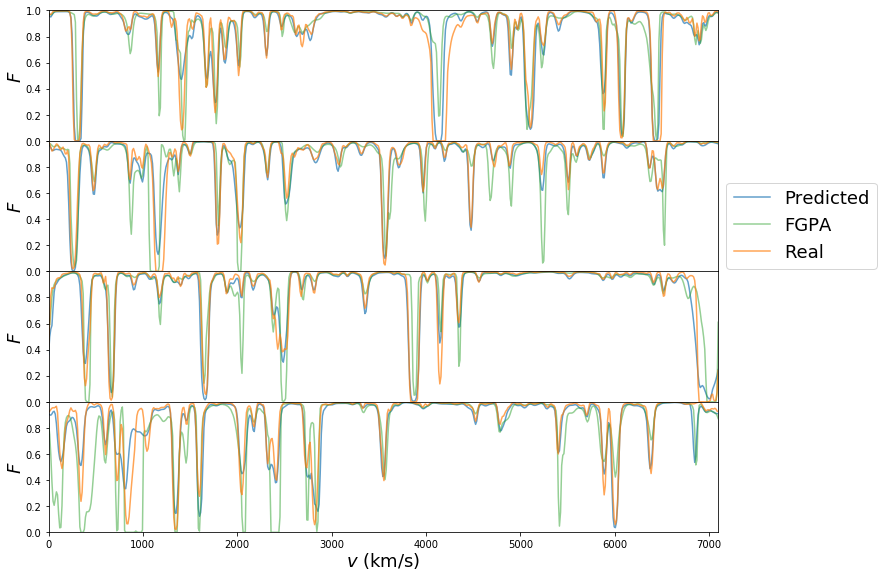

In [10]:
examples = 4
vaxis = np.arange(ske_len)/ske_len * v_end
order = np.random.randint(len(test_ske), size=examples)

fig, axes = plt.subplots(examples,1,figsize=(12,examples*2.4))

for i in range(examples):
    axes[i].plot(vaxis, test_outp[order[i]], label='Predicted',  alpha=0.7)
    axes[i].plot(vaxis, test_FGPA[order[i]], label='FGPA', color='tab:green', alpha=0.5)
    axes[i].plot(vaxis, test_ske[order[i]], label='Real', color='tab:orange', alpha=0.7)
    axes[i].set_xlim([0, max(vaxis)])
    axes[i].set_ylim([0,1])
    axes[i].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
    axes[i].set_ylabel(r'$F$', fontsize=18, labelpad=0.5)
    if i != int(examples-1):
        axes[i].set_xticklabels([])
axes[0].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[-1].set_xlabel(r'$v$ (km/s)', fontsize=18, labelpad=0.5)
axes[-1].legend(fontsize=18, bbox_to_anchor=(1.25,2.75))
plt.subplots_adjust(hspace=0)
#plt.savefig(folder_outp / ('examples.png'), dpi=600, bbox_inches='tight') 

Loading model...
Begin testing...
Step [ 100/5760] Loss: 0.3984, Time: 16.3560
Step [ 200/5760] Loss: 0.4081, Time: 32.9933
Step [ 300/5760] Loss: 0.3820, Time: 49.5194
Step [ 400/5760] Loss: 0.3718, Time: 65.9757
Step [ 500/5760] Loss: 0.4164, Time: 82.3720
Step [ 600/5760] Loss: 0.4676, Time: 97.0619
Step [ 700/5760] Loss: 0.5374, Time: 111.8131
Step [ 800/5760] Loss: 0.9237, Time: 126.2402
Step [ 900/5760] Loss: 0.4236, Time: 140.7355
Step [1000/5760] Loss: 0.8159, Time: 155.2102
Step [1100/5760] Loss: 0.8582, Time: 169.8966
Step [1200/5760] Loss: 0.4187, Time: 184.5417
Step [1300/5760] Loss: 0.5870, Time: 199.3709
Step [1400/5760] Loss: 0.5354, Time: 213.9981
Step [1500/5760] Loss: 0.3971, Time: 228.5779
Step [1600/5760] Loss: 0.3641, Time: 243.4872
Step [1700/5760] Loss: 0.3675, Time: 258.9345
Step [1800/5760] Loss: 0.4126, Time: 273.3654
Step [1900/5760] Loss: 0.5580, Time: 287.9541
Step [2000/5760] Loss: 0.7831, Time: 302.2241
Step [2100/5760] Loss: 0.5326, Time: 316.9052
Step [

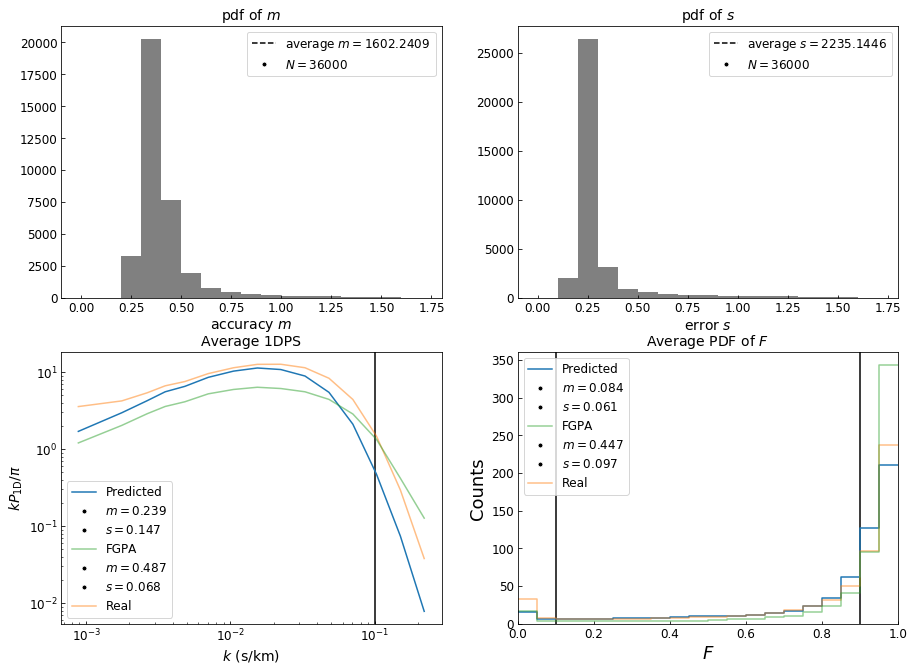

In [4]:
from scipy import optimize
def norm_specs(skewers,redshift):
    tauevo = 0.001845*(1+redshift)**3.924 #optical depth corresponding to the mean-flux of Faucher-Giguere et al. 2008 
    fobs = np.exp(-tauevo)
    def fun(a): return np.mean(np.exp(-a*skewers)-fobs)
    a = optimize.newton(fun, 1)    
    return a
rs = 2.0020281392528516 #redshift of the snapshot


# load model
print('Loading model...')
model = get_residual_network().float().to(device)
model.load_state_dict(torch.load('params/params_%s.pkl'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
'''
model.load_state_dict(torch.load('params/HyPhy_%s'\
        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
'''


# loss
criterion = nn.L1Loss()


# record starr time
start_time = time.time()


# start test
print('Begin testing...')
test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                        test_batch, train_insize, model, criterion, device, start_time)

print("Test Summary: ")
print("\tTest loss: {}".format(test_losses))

# restore test skewers
print('Restoring test skewers...')
nz = (ske_len/train_ousize[2]).astype('int')
test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
test_ske = test_ske.numpy().reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
test_FGPA = test_FGPA.numpy().reshape(-1, nz, train_ousize[0],
                            train_ousize[1], train_ousize[2])\
                            .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)

test_outp = toF_proc(test_outp)
test_ske  = toF_proc(test_ske)
test_FGPA = toF_proc(test_FGPA)

test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
del test_coord, xcoor, ycoor, mesh


print('Plotting example skewers...')
# generate comparison images
folder_outp = Path.cwd()/'test_figs'/('%s_x'\
        %time.strftime("%Y-%m-%d_%H:%M:%S_FGPA", localtime))
if not os.path.exists(folder_outp):
    os.makedirs(folder_outp)


from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
z = 2.0
h= 0.704
cosmo = FlatLambdaCDM(H0=100.0*h, Om0=0.2726, Ob0=0.0456)
Hz = cosmo.H(z)
a = 1.0 / (1.0 + z)
v_end  = (a * Hz * 75/h*u.Mpc).to(u.km / u.s).value
F_mean = np.array([test_ske.mean(), test_outp.mean(), test_FGPA.mean()])
print(F_mean)

nrange = min(len(test_ske), 50)
test_sp = np.arange(len(test_ske))
np.random.seed(99)
np.random.shuffle(test_sp)
test_sp1 = test_sp[:int(nrange)].astype('int')
test_sp2 = test_sp[int(nrange):].astype('int')

bins = int(15)
accuracy = AverageMeter()
rela_err = AverageMeter()
accu_arr = np.zeros(len(test_ske))
erro_arr = np.zeros(len(test_ske))
oneDPS   = np.zeros(shape=(4, len(test_ske), bins))


# loop
for i, ii in enumerate(test_sp1):
    print('Plotting {:{}d}/{}, y{:03d}z{:03d}.png...'\
            .format((i+1), int(np.log10(nrange)+1), nrange,
                    test_block[ii,0], test_block[ii,1]))

    test_block_i = test_block[ii]
    test_outp_i = test_outp[ii]
    test_ske_i = test_ske[ii]
    test_FGPA_i = test_FGPA[ii]
    test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

    stat_i = test_plot(test_block_i, test_outp_i, test_ske_i, test_FGPA_i,
                      test_DM_i, F_mean, v_end, folder_outp, bins)
    accuracy_i, rela_err_i = stat_i[[4,5]]
    accuracy.update(accuracy_i, 1)
    rela_err.update(rela_err_i, 1)
    accu_arr[ii] = accuracy_i
    erro_arr[ii] = rela_err_i
    oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2], stat_i[3]

print('Measuring accuracy of the left skewers...')
for i, ii in enumerate(test_sp2):

    test_block_i = test_block[ii]
    test_outp_i = test_outp[ii]
    test_ske_i = test_ske[ii]
    test_FGPA_i = test_FGPA[ii]
    test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

    stat_i = test_accuracy(test_block_i, test_outp_i, test_ske_i, test_FGPA_i,
                          F_mean, v_end, folder_outp, bins)
    accuracy_i, rela_err_i = stat_i[[4,5]]
    accuracy.update(accuracy_i, 1)
    rela_err.update(rela_err_i, 1)
    accu_arr[ii] = accuracy_i
    erro_arr[ii] = rela_err_i
    oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2], stat_i[3]


print('Plotting average 1DPS and PDF...')
#oneDPS_backup = oneDPS
oneDPS = oneDPS.mean(axis=1)
oneDPS = oneDPS[~np.isnan(oneDPS)].reshape(4,-1)
bln = oneDPS[0]<0.1
accuracy_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].mean()
rela_err_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].std()
accuracy_FGPA = np.abs((oneDPS[3]-oneDPS[2])/oneDPS[2])[bln].mean()
rela_err_FGPA = np.abs((oneDPS[3]-oneDPS[2])/oneDPS[2])[bln].std()

outp_hist, F_hist = np.histogram(test_outp, bins=np.arange(0,1.05,0.05))
test_hist, F_hist = np.histogram(test_ske,  bins=np.arange(0,1.05,0.05))
FGPA_hist, F_hist = np.histogram(test_FGPA, bins=np.arange(0,1.05,0.05))
outp_hist = np.append(outp_hist, outp_hist[-1]) / len(test_ske)
test_hist = np.append(test_hist, test_hist[-1]) / len(test_ske)
FGPA_hist = np.append(FGPA_hist, FGPA_hist[-1]) / len(test_ske)
bln = (F_hist>=0.1) & (F_hist<0.9)
accuracy_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].mean()
rela_err_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].std()
m_hist_FGPA = np.abs((FGPA_hist-test_hist)/test_hist)[bln].mean()
s_hist_FGPA = np.abs((FGPA_hist-test_hist)/test_hist)[bln].std()


fig, axes = plt.subplots(2,2,figsize=(15,11))

p0=axes[0,0].hist(accu_arr, color='grey', bins=np.arange(0, 1.7, 0.1))
axes[0,0].set_xlim(-0.1, 1.8)
axes[0,0].set_ylim(axes[0,0].get_ylim())
p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
axes[0,0].set_title('pdf of $m$', fontsize=14)
axes[0,0].tick_params(labelsize=12, direction='in')
customs = [p1, 
          Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='k', markersize=5)]
axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                        '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

axes[0,1].hist(erro_arr, color='grey', bins=np.arange(0, 1.7, 0.1))
axes[0,1].set_xlim(-0.1, 1.8)
axes[0,1].set_ylim(axes[0,1].get_ylim())
p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
axes[0,1].set_xlabel('error $s$', fontsize=14)
axes[0,1].set_title('pdf of $s$', fontsize=14)
axes[0,1].tick_params(labelsize=12, direction='in')
customs = [p2, 
          Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='k', markersize=5)]
axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                        '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
p4, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
p7, = axes[1,0].plot(oneDPS[0], oneDPS[3], label='FGPA', alpha=0.5)
axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(axes[1,0].get_ylim())
axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
axes[1,0].set_title('Average 1DPS', fontsize=14)
axes[1,0].tick_params(labelsize=12, direction='in', which='both')
customs = [p3,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p7,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p4]
axes[1,0].legend(customs, [p3.get_label(), '$m=%.3f$'%accuracy_gen, '$s=%.3f$'%rela_err_gen, 
                    p7.get_label(),'$m=%.3f$'%accuracy_FGPA, '$s=%.3f$'%rela_err_FGPA,
                    p4.get_label()], fontsize=12)

p5, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
p6, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
p8, = axes[1,1].step(F_hist, FGPA_hist, where='post', label='FGPA', alpha=0.5)
axes[1,1].set_xlabel(r'$F$', fontsize=18)
axes[1,1].set_ylabel(r'Counts', fontsize=18)
axes[1,1].set_xlim([0, 1])
axes[1,1].set_ylim(bottom=0)
axes[1,1].vlines(x=0.1, ymin=0, ymax=6000)
axes[1,1].vlines(x=0.9, ymin=0, ymax=6000)
axes[1,1].set_title('Average PDF of $F$', fontsize=14)
axes[1,1].tick_params(labelsize=12, direction='in')
customs = [p5,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p8,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p6]
axes[1,1].legend(customs, [p5.get_label(), '$m=%.3f$'%accuracy_hist, '$s=%.3f$'%rela_err_hist,
                    p8.get_label(),'$m=%.3f$'%m_hist_FGPA, '$s=%.3f$'%s_hist_FGPA,
                    p6.get_label()], fontsize=12)

#plt.savefig(folder_outp / ('average.png'), dpi=300, bbox_inches='tight') 

In [ ]:
# this is unnormalized